# Evaluate Model
This notebooks loads a specific model so that you can evaluate it.

In [11]:
import sys
sys.path.insert(0, '../')

import torch
import numpy as np
import pylab as plt

from models import build_model
from datasets import build_dataset, build_ood_datasets
from metrics import calibration, ood, generalization
from tqdm.auto import tqdm

In [12]:
# Loading model
checkpoint = torch.load('../results/CIFAR10__wideresnet2810_sngp/seed3/checkpoint.pth')
model_dict = build_model(checkpoint['args'], n_classes=10, train_ds=None)
model = model_dict['model']
model(torch.randn(1, 3, 32, 32))
model.load_state_dict(checkpoint['model'])

# Load datasets
train_ds, test_ds, ds_info = build_dataset(checkpoint['args'])
ood_datasets = build_ood_datasets(checkpoint['args'], ds_info['mean'], ds_info['std'])
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, sampler=None)# range(1000))
ood_loader = torch.utils.data.DataLoader(ood_datasets['SVHN'], batch_size=256, sampler=None)# range(1000))

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [13]:
# forward prop
device = 'cuda'
model.to(device)
model.eval()

logits, targets = [], []
for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        logits.append(model(inp.to(device), mean_field=True).cpu())
        targets.append(tar)
logits = torch.cat(logits)
targets = torch.cat(targets)

logits_ood = []
for inp, tar in tqdm(ood_loader):
    with torch.no_grad():
        logits_ood.append(model(inp.to(device), mean_field=True).cpu())
logits_ood = torch.cat(logits_ood)

100%|██████████| 102/102 [00:19<00:00,  5.34it/s]


In [14]:
# Compute results
entropy_id = ood.entropy_fn(logits.softmax(-1))
entropy_ood = ood.entropy_fn(logits_ood.softmax(-1))
tce_criterion = calibration.TopLabelCalibrationError()
nll_criterion = torch.nn.CrossEntropyLoss()

results = {
    'ACC': generalization.accuracy(logits, targets)[0].item(),
    'TCE': tce_criterion(logits.softmax(-1), targets).item(),
    'NLL': nll_criterion(logits, targets).item(),
    'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
}
print(results)

{'ACC': 96.18000030517578, 'TCE': 0.017084406688809395, 'NLL': 0.13503894209861755, 'AUROC': 0.8940567417025199}


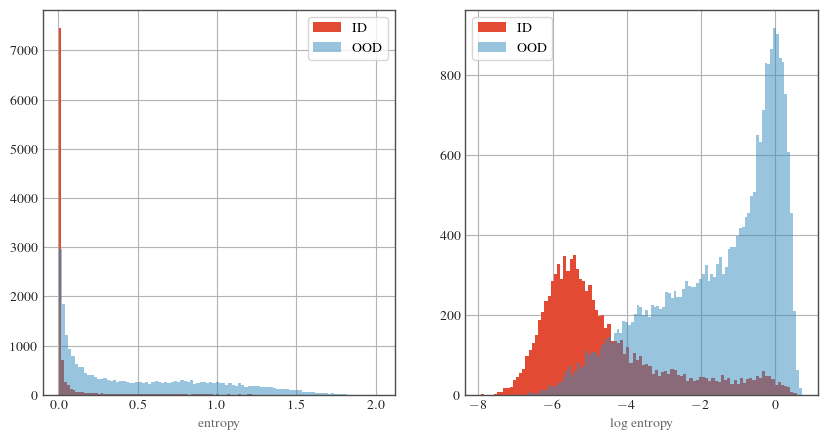

In [15]:
# Plot ood histogram
plt.subplot(121)
plt.hist(entropy_id, bins=100, label='ID')
plt.hist(entropy_ood, bins=100, alpha=.5, label='OOD')
plt.xlabel('entropy')

plt.legend()
plt.subplot(122)
plt.hist(entropy_id.log(), bins=100, label='ID')
plt.hist(entropy_ood.log(), bins=100, alpha=.5, label='OOD')
plt.xlabel('log entropy')
plt.legend()
plt.show()

<BarContainer object of 15 artists>

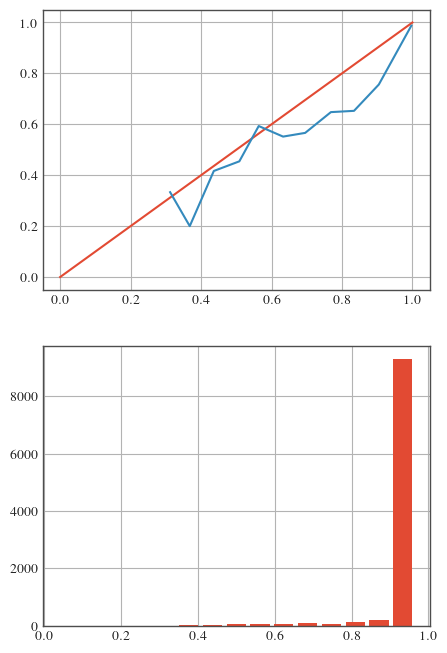

In [16]:
# Plot reliability diagram
tcp_dict = tce_criterion.results
plt.figure(figsize=(5, 8))
plt.subplot(211)
plt.plot([0, 1], [0, 1])
plt.plot(tcp_dict['confs'], tcp_dict['accs'])
plt.subplot(212)
plt.bar(np.linspace(1/15, 1-1/15, 15), tcp_dict['n_samples'], width=.05)

In [17]:
results = []
mean_field_factors = np.linspace(0.1, 20, 25)
for mean_field_factor in mean_field_factors:
    # forward prop
    device = 'cuda'
    model.to(device)
    model.eval()
    print('Running mean field factor of', mean_field_factor)
    model.output_layer.mean_field_factor = mean_field_factor

    logits, targets = [], []
    for inp, tar in tqdm(test_loader):
        with torch.no_grad():
            logits.append(model(inp.to(device), mean_field=True).cpu())
            targets.append(tar)
    logits = torch.cat(logits)
    targets = torch.cat(targets)

    logits_ood = []
    for inp, tar in tqdm(ood_loader):
        with torch.no_grad():
            logits_ood.append(model(inp.to(device), mean_field=True).cpu())
    logits_ood = torch.cat(logits_ood)

    # Compute results
    entropy_id = ood.entropy_fn(logits.softmax(-1))
    entropy_ood = ood.entropy_fn(logits_ood.softmax(-1))
    tce_criterion = calibration.TopLabelCalibrationError()
    nll_criterion = torch.nn.CrossEntropyLoss()

    result_dict = {
        'ACC': generalization.accuracy(logits, targets)[0].item(),
        'TCE': tce_criterion(logits.softmax(-1), targets).item(),
        'NLL': nll_criterion(logits, targets).item(),
        'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
    }
    results.append(result_dict)
    print(result_dict)


Running mean field factor of 0.1


100%|██████████| 102/102 [00:19<00:00,  5.34it/s]


{'ACC': 96.18000030517578, 'TCE': 0.020097915083169937, 'NLL': 0.14243705570697784, 'AUROC': 0.8630671807775046}
Running mean field factor of 0.9291666666666666


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.18000030517578, 'TCE': 0.011325119994580746, 'NLL': 0.12836535274982452, 'AUROC': 0.9167777197295637}
Running mean field factor of 1.7583333333333333


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.18000030517578, 'TCE': 0.008382857777178288, 'NLL': 0.128306582570076, 'AUROC': 0.9303027350952674}
Running mean field factor of 2.5875


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.18000030517578, 'TCE': 0.015344415791332722, 'NLL': 0.13605400919914246, 'AUROC': 0.9372322334050401}
Running mean field factor of 3.4166666666666665


100%|██████████| 102/102 [00:19<00:00,  5.33it/s]


{'ACC': 96.18000030517578, 'TCE': 0.03221414238214493, 'NLL': 0.14908219873905182, 'AUROC': 0.9416883047787339}
Running mean field factor of 4.245833333333333


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.18000030517578, 'TCE': 0.0507497563958168, 'NLL': 0.16586050391197205, 'AUROC': 0.944873336662569}
Running mean field factor of 5.074999999999999


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.18000030517578, 'TCE': 0.07061129808425903, 'NLL': 0.18531255424022675, 'AUROC': 0.9472950157498462}
Running mean field factor of 5.904166666666666


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.18000030517578, 'TCE': 0.09121019393205643, 'NLL': 0.2066396176815033, 'AUROC': 0.9492077961739397}
Running mean field factor of 6.7333333333333325


100%|██████████| 102/102 [00:19<00:00,  5.33it/s]


{'ACC': 96.18000030517578, 'TCE': 0.11203230172395706, 'NLL': 0.22923722863197327, 'AUROC': 0.9507621120159806}
Running mean field factor of 7.562499999999999


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


{'ACC': 96.18000030517578, 'TCE': 0.1328115314245224, 'NLL': 0.2526450753211975, 'AUROC': 0.95206471266134}
Running mean field factor of 8.391666666666666


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


{'ACC': 96.18000030517578, 'TCE': 0.15329360961914062, 'NLL': 0.27651214599609375, 'AUROC': 0.9531678703134603}
Running mean field factor of 9.220833333333333


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


{'ACC': 96.18000030517578, 'TCE': 0.1733098328113556, 'NLL': 0.3005712032318115, 'AUROC': 0.9541188806084818}
Running mean field factor of 10.049999999999999


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


{'ACC': 96.18000030517578, 'TCE': 0.19282391667366028, 'NLL': 0.32461991906166077, 'AUROC': 0.9549485517824219}
Running mean field factor of 10.879166666666665


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.18000030517578, 'TCE': 0.21152250468730927, 'NLL': 0.34850582480430603, 'AUROC': 0.9556782114320836}
Running mean field factor of 11.708333333333332


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.18000030517578, 'TCE': 0.22963348031044006, 'NLL': 0.3721151351928711, 'AUROC': 0.9563239147971726}
Running mean field factor of 12.5375


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.24698561429977417, 'NLL': 0.39536434412002563, 'AUROC': 0.9569034572833435}
Running mean field factor of 13.366666666666665


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.2636115550994873, 'NLL': 0.41819292306900024, 'AUROC': 0.9574277139674247}
Running mean field factor of 14.195833333333331


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


{'ACC': 96.18000030517578, 'TCE': 0.2795584797859192, 'NLL': 0.44055843353271484, 'AUROC': 0.9579029828672403}
Running mean field factor of 15.024999999999999


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.2947019338607788, 'NLL': 0.46243253350257874, 'AUROC': 0.9583392190381068}
Running mean field factor of 15.854166666666666


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.3092278242111206, 'NLL': 0.483797550201416, 'AUROC': 0.9587374135679163}
Running mean field factor of 16.683333333333334


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.3230978846549988, 'NLL': 0.5046440958976746, 'AUROC': 0.9591038913644746}
Running mean field factor of 17.5125


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.3363398611545563, 'NLL': 0.5249693393707275, 'AUROC': 0.959445033036263}
Running mean field factor of 18.34166666666667


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.3489825129508972, 'NLL': 0.5447750091552734, 'AUROC': 0.9597606311462815}
Running mean field factor of 19.170833333333334


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]


{'ACC': 96.18000030517578, 'TCE': 0.361054927110672, 'NLL': 0.5640667676925659, 'AUROC': 0.9600530500921941}
Running mean field factor of 20.0


100%|██████████| 102/102 [00:19<00:00,  5.27it/s]

{'ACC': 96.18000030517578, 'TCE': 0.3725861608982086, 'NLL': 0.5828529000282288, 'AUROC': 0.9603243757682851}


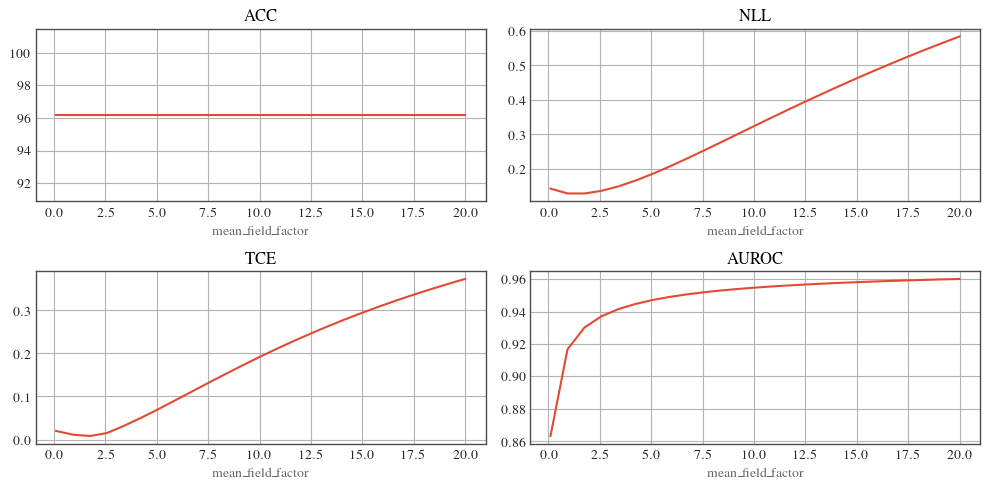

In [19]:
plt.subplot(221)
plt.title('ACC')
plt.plot(mean_field_factors, [d['ACC'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(222)
plt.title('NLL')
plt.plot(mean_field_factors, [d['NLL'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(223)
plt.title('TCE')
plt.plot(mean_field_factors, [d['TCE'] for d in results])
plt.xlabel('mean_field_factor')

plt.subplot(224)
plt.title('AUROC')
plt.plot(mean_field_factors, [d['AUROC'] for d in results])
plt.xlabel('mean_field_factor')

plt.tight_layout()
plt.show()